In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import healpy as hp

sys.path.append(os.path.expanduser('~/git/desi-examples/imaging_systematics'))
from plot_healpix_map import plot_map

In [2]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
nmad = lambda x: 1.4826 * np.nanmedian(np.abs(x-np.nanmedian(x)))

---------
## DEC<-30 offset

In [4]:
nside = 128
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/gaia_dr3/misc/gaia_xp_dr9_south_offset_maps_{}.fits'.format(nside)))

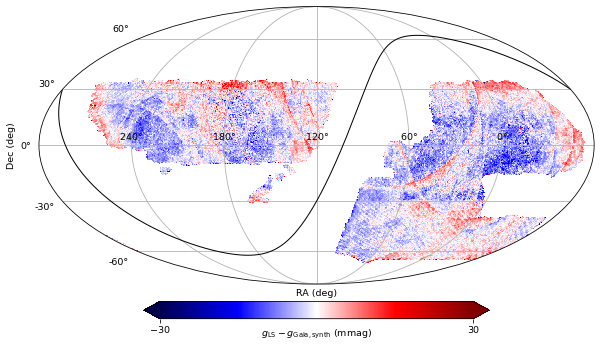

Done! 00:00:01


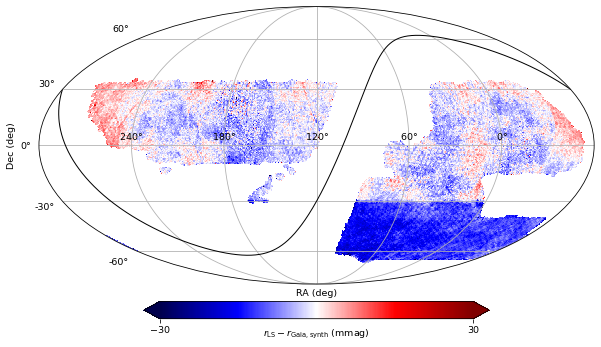

Done! 00:00:01


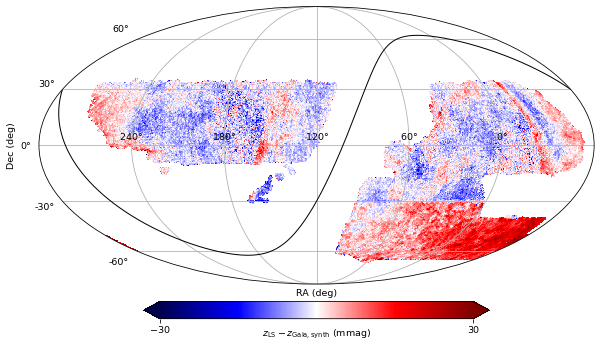

Done! 00:00:01


In [5]:
for band in ['g', 'r', 'z']:
    mask = np.isfinite(cat[band+'mag_diff_median'])
    plot_map(nside, 1000*cat[band+'mag_diff_median'][mask], pix=cat['HPXPIXEL'][mask], dpi=100, xsize=1000, cmap='seismic',
             vmin=-30, vmax=30, cbar_label='${}_\mathrm{{LS}}-{}_\mathrm{{Gaia,synth}}$ (mmag)'.format(band, band),
             show=True)

g median (mean):  -0.3 ( -0.1)
r median (mean): -12.6 (-12.6)
z median (mean):   7.6 (  8.3)


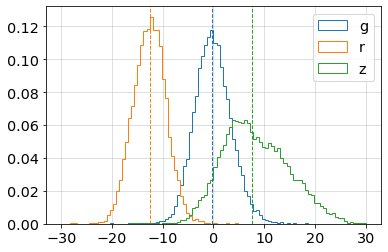

In [6]:
for index, band in enumerate(['g', 'r', 'z']):
    mask = np.isfinite(cat[band+'mag_diff_median'])
    mask &= cat[band+'mag_n_objects']>=20
    mask &= cat['DEC']<-30
    print(band+' median (mean): {:5.1f} ({:5.1f})'.format(1000*np.median(cat[band+'mag_diff_median'][mask]), 1000*np.mean(cat[band+'mag_diff_median'][mask])))
    plt.hist(1000*cat[band+'mag_diff_median'][mask], 100, range=(-30, 30), alpha=1., label=band, histtype='step', density=True, color='C'+str(index))
    plt.axvline(1000*np.nanmedian(cat[band+'mag_diff_median'][mask]), color='C'+str(index), lw=1, ls='--')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

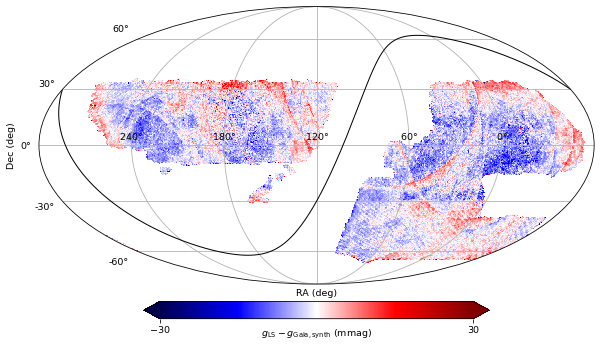

Done! 00:00:01


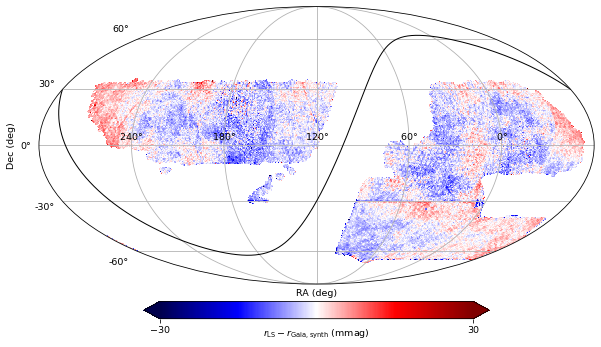

Done! 00:00:01


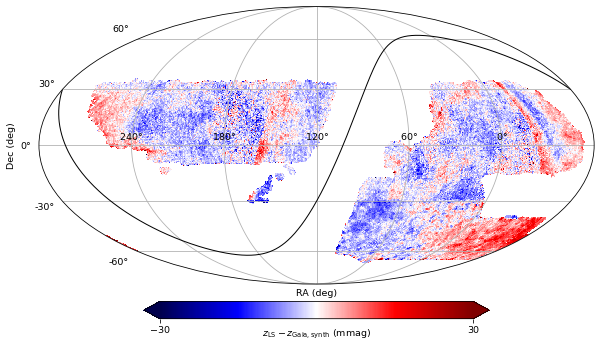

Done! 00:00:01


In [7]:
# try constant offset
offset_dict = {'g':0., 'r':-12.6, 'z':7.6}
for band in ['g', 'r', 'z']:
    cat[band+'mag_diff_median1'] = cat[band+'mag_diff_median'].copy()
    mask &= cat['DEC']<-30
    cat[band+'mag_diff_median1'][mask] -= offset_dict[band]/1000.
    
for band in ['g', 'r', 'z']:
    mask = np.isfinite(cat[band+'mag_diff_median1'])
    plot_map(nside, 1000*cat[band+'mag_diff_median1'][mask], pix=cat['HPXPIXEL'][mask], dpi=100, xsize=1000, cmap='seismic',
             vmin=-30, vmax=30, cbar_label='${}_\mathrm{{LS}}-{}_\mathrm{{Gaia,synth}}$ (mmag)'.format(band, band),
             show=True)

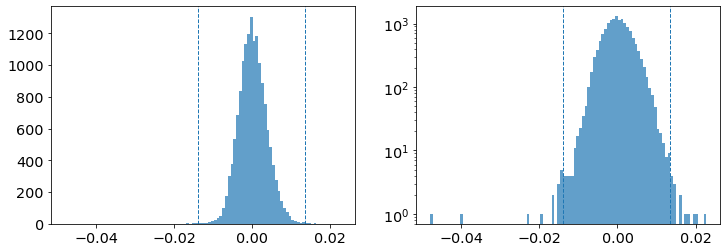

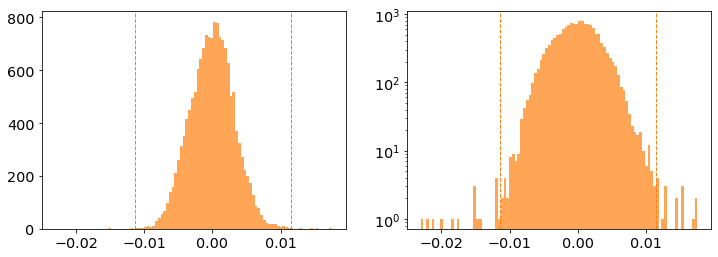

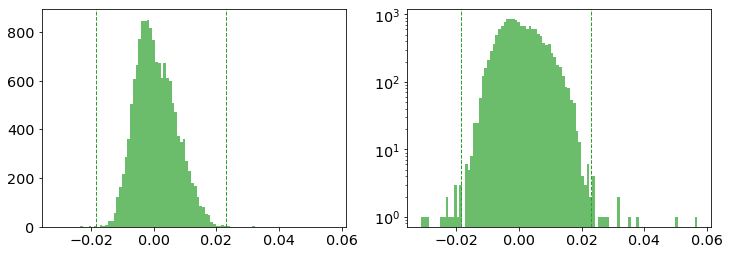

In [63]:
limits_dict = {}
for index, band in enumerate(['g', 'r', 'z']):
    v = cat[band+'mag_diff_median']
    mask = np.isfinite(cat[band+'mag_diff_median'])
    mask &= cat[band+'mag_n_objects']>=20
    mask &= cat['DEC']<-30
    mask &= (cat['RA']<120) | (cat['RA']>290)
    mask &= ~(((cat['RA']>290) & (cat['RA']<358)) & (cat['DEC']>-40))
    limits_dict[band] = np.percentile(v[mask], [0.1, 99.9])
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].hist(v[mask], 100, log=False, alpha=0.7, color='C'+str(index))
    ax[0].axvline(limits_dict[band][0], lw=1, color='C'+str(index), ls='--')
    ax[0].axvline(limits_dict[band][1], lw=1, color='C'+str(index), ls='--')
    ax[1].hist(v[mask], 100, log=True, alpha=0.7, color='C'+str(index))
    ax[1].axvline(limits_dict[band][0], lw=1, color='C'+str(index), ls='--')
    ax[1].axvline(limits_dict[band][1], lw=1, color='C'+str(index), ls='--')
    plt.show()

In [64]:
limits_dict

{'g': array([-0.01395826,  0.01353853]),
 'r': array([-0.01142836,  0.01147967]),
 'z': array([-0.01844032,  0.0230391 ])}

0.00013570373241501819
(-0.005990341415443844, array([ 0.00732357, -0.00037836, -0.00413991]))


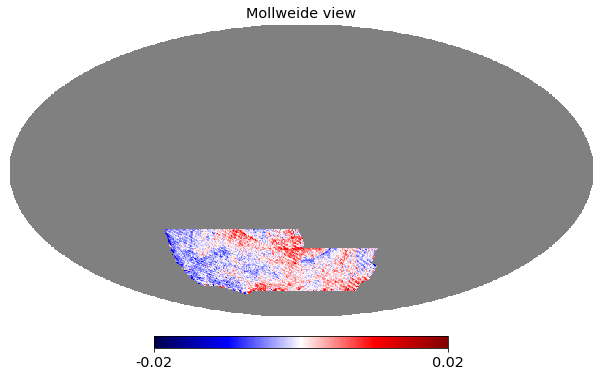

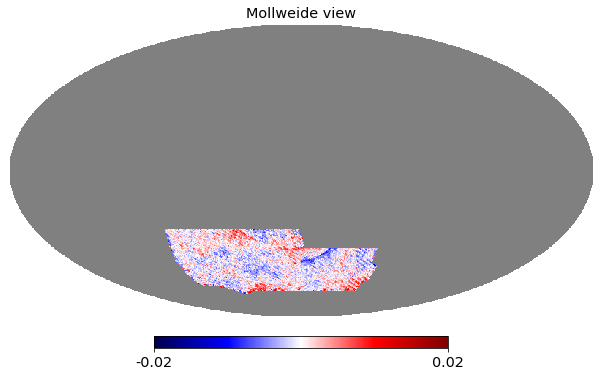

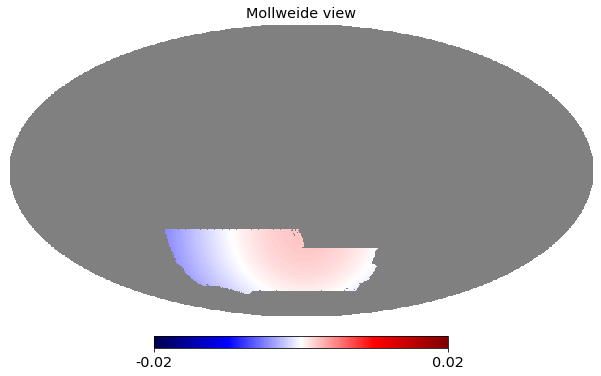

--------------------------------------------------------
-5.998906851583873e-05
(0.007151826612218481, array([ 0.00253447, -0.00363545,  0.01021869]))


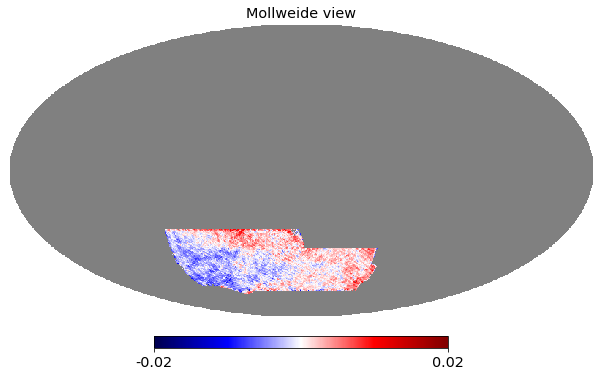

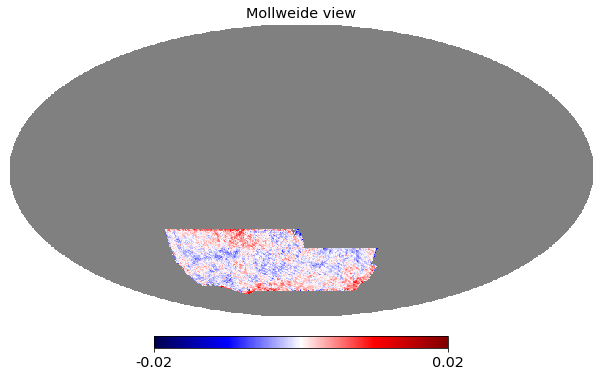

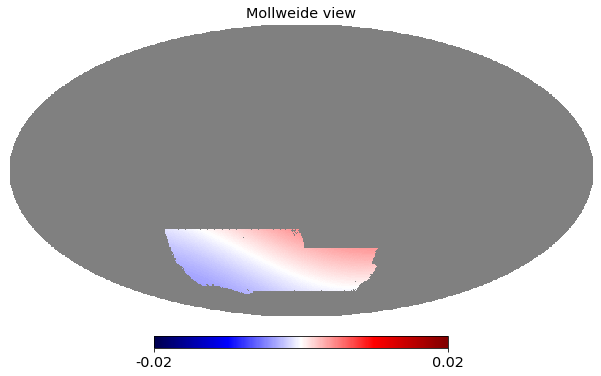

--------------------------------------------------------
0.0006923380382763614
(0.006813123096744242, array([ 6.41211157e-05, -1.35882444e-02,  3.91261375e-03]))


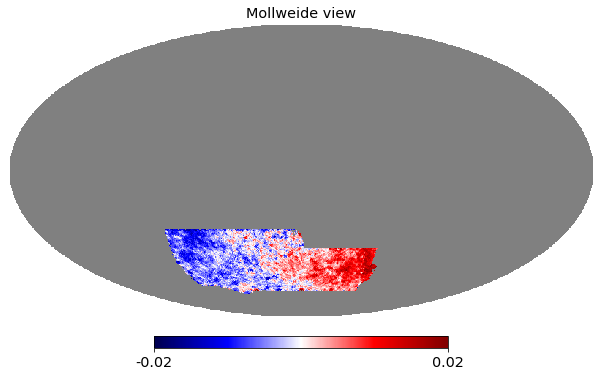

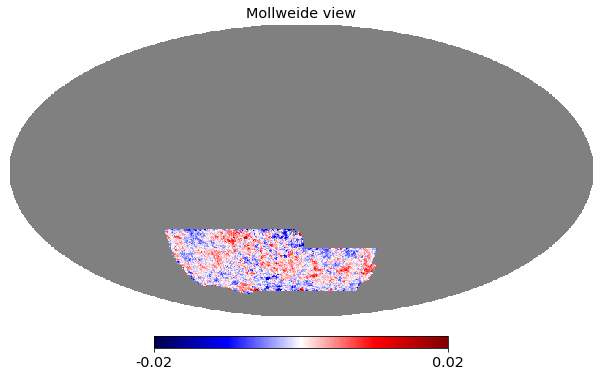

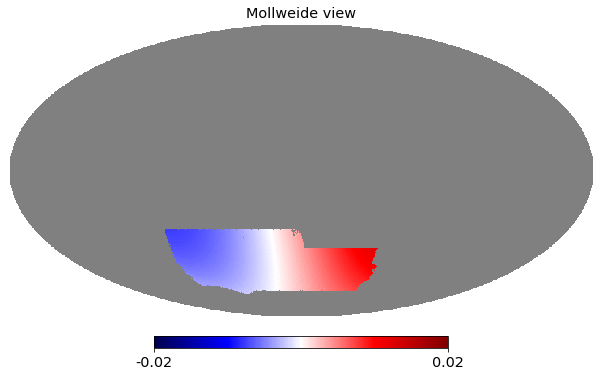

--------------------------------------------------------


In [65]:
dipole_maps = {}

for band in ['g', 'r', 'z']:
    v = cat[band+'mag_diff_median']
    mask = np.isfinite(cat[band+'mag_diff_median'])
    mask &= cat[band+'mag_n_objects']>=20
    mask &= cat['DEC']<-30
    mask &= (cat['RA']<120) | (cat['RA']>290)
    mask &= ~(((cat['RA']>290) & (cat['RA']<358)) & (cat['DEC']>-40))
    mask &= (v>limits_dict[band][0]) & (v<limits_dict[band][1])
    npix = hp.nside2npix(nside)

    hp_mask = np.zeros(npix, dtype=bool)
    map_values = np.zeros(npix, dtype=v.dtype)
    map_values[cat['HPXPIXEL'][mask]] = np.array(v[mask])
    hp_mask[cat['HPXPIXEL'][mask]] = True
    hpcat = hp.ma(map_values)
    hpcat.mask = ~hp_mask

    monopole=hp.fit_monopole(hpcat)
    print(monopole)
    aa = hp.remove_monopole(hpcat)
    hp.mollview(aa, cmap='seismic', min=-0.02, max=0.02)

    diploe = hp.fit_dipole(hpcat)
    print(diploe)

    bb = hp.remove_dipole(hpcat)
    hp.mollview(bb, cmap='seismic', min=-0.02, max=0.02)
    
    bb = hp.remove_dipole(hpcat)
    hp.mollview(aa-bb, cmap='seismic', min=-0.02, max=0.02)
    plt.show()
    
    dipole_maps[band] = (aa-bb).copy()
    
    print('--------------------------------------------------------')

g median (mean):   0.5 ( -0.0)
r median (mean):  -0.0 (  0.0)
z median (mean):  -1.1 ( -0.0)


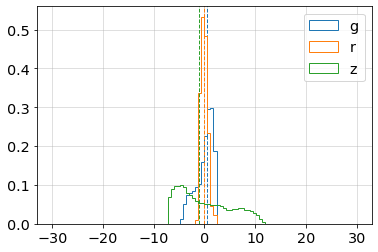

In [60]:
for index, band in enumerate(['g', 'r', 'z']):
    dipole = dipole_maps[band]
    mag_diff = dipole.data[~dipole.mask]
    print(band+' median (mean): {:5.1f} ({:5.1f})'.format(1000*np.median(mag_diff), 1000*np.mean(mag_diff)))
    plt.hist(1000*mag_diff, 100, range=(-30, 30), alpha=1., label=band, histtype='step', density=True, color='C'+str(index))
    plt.axvline(1000*np.nanmedian(mag_diff), color='C'+str(index), lw=1, ls='--')
plt.grid(alpha=0.5)
plt.legend()
plt.show()